<a href="https://colab.research.google.com/github/Berenice2018/DeepLearning/blob/master/FER_CNN_from_scratch_Berenice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import json
import numpy as np
import time
import datetime
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import os, cv2
import pandas as pd
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 10

print(torch.__version__)

1.1.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Convert and save images to GDrive

In [0]:
#! /usr/bin/env python3
# -*-coding: utf-8-*-

#!pip install mxnet

__author__ = 'Moonkie'

import numpy as np
import cv2
import mxnet as mx
import pandas as pd
import random
import os

curdir = os.path.abspath(os.path.dirname(fer))

def gen_record(csvfile,channel):
    data = pd.read_csv(csvfile,delimiter=',',dtype='a')
    labels = np.array(data['emotion'],np.float)
    # print(labels,'\n',data['emotion'])
        
    imagebuffer = np.array(data['pixels'])
    images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
    del imagebuffer
    num_shape = int(np.sqrt(images.shape[-1]))
    images.shape = (images.shape[0],num_shape,num_shape)
    # img=images[0];cv2.imshow('test',img);cv2.waitKey(0);cv2.destroyAllWindow();exit()
    dirs = set(data['Usage'])
    subdirs = set(labels)
    class_dir = {}
    for dr in dirs:
        dest = os.path.join(curdir,dr)
        class_dir[dr] = dest
        if not os.path.exists(dest):
            os.mkdir(dest)
            
    data = zip(labels,images,data['Usage'])
    
    for d in data:
        destdir = os.path.join(class_dir[d[-1]],str(int(d[0])))
        if not os.path.exists(destdir):
            os.mkdir(destdir)
        img = d[1]
        filepath = unique_name(destdir,d[-1])
        print('[^_^] Write image to %s' % filepath)
        if not filepath:
            continue
        sig = cv2.imwrite(filepath,img)
        if not sig:
            print('Error')
            exit(-1)


def unique_name(pardir,prefix,suffix='jpg'):
    filename = '{0}_{1}.{2}'.format(prefix,random.randint(1,10**8),suffix)
    filepath = os.path.join(pardir,filename)
    if not os.path.exists(filepath):
        return filepath
    unique_name(pardir,prefix,suffix)
    


if __name__ == '__main__':
    filename = 'fer2013.csv'
    filename = os.path.join(curdir,filename)
    gen_record(filename,1)
    
    # ##################### test
    # tmp = unique_name('./Training','Training')
    # print(tmp)

### Load data , image transform

In [6]:
fer= "./gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013/fer2013.csv"
ferr= "./gdrive/My Drive/Colab Notebooks/Fer-dataset"

!ls   '/content/gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013/'

fer2013.bib  fer2013.csv  PrivateTest  PublicTest  README  Training


In [16]:
data_dir = "./gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013"
train_dir = data_dir + '/Training'
valid_dir = data_dir + '/PublicTest'
test_dir = data_dir + '/PrivateTest'

# original img size = 48 x48 px
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomResizedCrop(256),
        transforms.Resize(256), #320
        transforms.ToTensor(),
        transforms.Normalize([0.485,], 
                             [0.229, ])
    ]),
    'valid': transforms.Compose([
        #transforms.CenterCrop(256),
        transforms.Resize(256),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    }

# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'valid': valid_dir,
        'test': test_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=7) 
               for x in ['train', 'valid','test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'valid','test']}
print(dataset_sizes)

{'train': 32556, 'valid': 3589, 'test': 3589}


In [8]:
class_names = datasets['train'].classes
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


### Show some sample images

In [0]:
# get a batch of training images
dataiter = iter(dataloaders['train'])
images, _ = dataiter.next()
images = images.numpy() # convert images to numpy

# plot the images of the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))  # convert from Tensor image

### Helpers

In [0]:
def get_time():
      hour = datetime.datetime.today().hour +2
      minute = datetime.datetime.today().minute
      second = datetime.datetime.today().second
      return hour, minute, second
    
    
def weights_init_normal(m):
  '''Takes in a module and initializes all linear layers with weight
     values taken from a normal distribution.'''
  classname = m.__class__.__name__
  # for every Linear layer in a model
  if classname.find('Linear') != -1:
      n = m.in_features
      # m.weight.data shoud be taken from a normal distribution
      m.weight.data.normal_(0, 1/np.sqrt(n))
      # m.bias.data should be 0
      m.bias.data.fill_(0)
      
      
# Visualize plot
def plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    ax1.plot(valid_losses, label='Validation loss')
    ax1.plot(train_losses, label='Training loss')
    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    #x_ticks = [x for x in range(0,n_epochs,2)]
    #plt.xticks(x_ticks)
    
    ax2.plot(valid_accuracies, label = 'Validation accuracy')
    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    
    plt.tight_layout()

### Architecture & train functions

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        n = m.in_features
        # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0, 1/np.sqrt(n))
        # m.bias.data should be 0
        m.bias.data.fill_(0)
        
        
# normalize each layer:
class MyBatchNormLayer(nn.Module):
    def __init__(self, input_number, filter_number, stride=2, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(input_number, filter_number, kernel_size=kernel_size,
                             stride=stride, bias=False, padding=1)
        self.normalized = nn.BatchNorm2d(filter_number)
    
    def forward(self,x):
        x = F.relu(self.conv(x))
        #print('MyBatchNormLayer x.shape= ', x.shape)
        return self.normalized(x)

    
class ResnetLayer(MyBatchNormLayer):
    def forward(self, x): return x + super().forward(x)
    
    
class MyConvBnNet(nn.Module):
    def __init__(self, layers, classes_number, dropout=0):
        super().__init__()
        # define the first convolutional layer manually
        self.conv1 = MyBatchNormLayer(3, 64,kernel_size=7, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(3,2)
        
        self.layers1 = nn.ModuleList([MyBatchNormLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers4 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers5 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers6 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers7 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers8 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        
        #self.linear1 = nn.Linear(layers[-1], 512)
        self.outlayer = nn.Linear(layers[-1], classes_number)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        for lyr1 ,lyr2, lyr3, lyr4, lyr5, lyr6 in zip(
            self.layers1, self.layers2, self.layers3, self.layers4, self.layers5, self.layers6): 
            x = lyr4(lyr3(lyr2(lyr1(x))))
            x =  lyr6(lyr5(x)) # lyr8(lyr7(lyr6(lyr5(x))))
        x = F.adaptive_max_pool2d(x,1)
        #print('MyConvBnNet after adaptive_max_pool2d, x.shape=', x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        #x = self.linear1(x)
        x = self.outlayer(x)
        return F.log_softmax(x, dim= -1)


# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('cuda available: ', use_cuda)

# instantiate the CNN
#model_scratch = MyConvBnNet([10, 20, 40], 133)
model_scratch = MyConvBnNet([64, 128, 256, 512, 1024], 7, 0.1)
print(model_scratch)

model_scratch.apply(weights_init_normal)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
print('model is on cuda: ', next(model_scratch.parameters()).is_cuda)

In [0]:

def train_epoch(model, dataloader, criterion, optimizer, train_on_gpu):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        ## find the loss and update the model parameters accordingly
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # get the loss per batch and accumulate
        train_loss += loss.item()
        
        # get the class, highest probability
        probabilities = torch.exp(output)
        _, top_class = probabilities.topk(1, dim=1)
        # The following line is equivalent to the previous (?)
        #_, top_class = torch.max(probabilities, dim=1)
        
        # check if the predicted class is correct
        equals = top_class == target.view(*top_class.shape)
        # 
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    return train_loss, train_accuracy


def validate_epoch(model, dataloader, criterion, train_on_gpu):
    valid_loss = 0.0
    valid_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            
            valid_loss += loss.item()

            ps = torch.exp(output)
            _ , top_class = ps.topk(1,dim = 1)
            #_, top_class = torch.max(ps, dim=1)
            equals = top_class == target.view(*top_class.shape) # shape is (batch size x 1)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))

    return valid_loss, valid_accuracy

In [0]:

def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    print('Training started at ', get_time())
    
    valid_losses = []
    train_losses = []
    valid_accuracies = []
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(n_epochs):
        
         # initialize variables to monitor training and validation loss
        training_loss = 0.0
        training_accuracy = 0.0
    
        if scheduler is not None:
          scheduler.step()
        
        ###################
        # train the model #
        model.train()
        training_loss, training_accuracy = train_epoch(model, loaders['train'], criterion, optimizer, use_cuda)
    
        
        ######################    
        # validate the model #
        model.eval()
        validation_loss, validation_accuracy = validate_epoch(model, loaders['valid'], criterion, use_cuda)
        
        #if scheduler is not None:
          #scheduler.step(validation_loss)
        
        ###### print training/validation statistics 
        # calculate the average loss per epoch
        training_loss = training_loss/len(loaders['train'])
        train_losses.append(training_loss)
        
        training_accuracy = training_accuracy/len(loaders['train'])
        
        validation_loss = validation_loss/len(loaders['valid'])
        valid_losses.append(validation_loss)
        
        validation_accuracy = validation_accuracy/len(loaders['valid'])
        valid_accuracies.append(validation_accuracy)
        
        hour, minute, second = get_time()
        print('Epoch: {} at {}:{}:{} \tTrain. Loss: {:.6f} \tValid. Loss: {:.6f} \t Accur.: {:.10f}'.format(
                  epoch,
                  hour, minute, second,
                  training_loss,
                  #training_accuracy, 
                  validation_loss,
                  validation_accuracy ))
        
        ###### TODO: save the model if validation loss has decreased
        if validation_loss <= valid_loss_min:
            '''print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                validation_loss))'''
            print('Validation loss decreased by {:.6f}'.format(validation_loss - valid_loss_min))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = validation_loss
            
            
    ##### visualize
    plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies)
    
    return model


### Hyper params & Start the training

./gdrive/My Drive/Colab Notebooks/Fer-dataset/cnn-Adam-lr0.0001-Multi_10_18_26_32-epo2.pt
Training started at  (16, 8, 53)
Epoch: 0 at 16:15:14 	Train. Loss: 1.814801 	Valid. Loss: 2.318085 	 Accur.: 0.4303728044
Validation loss decreased by -inf
Epoch: 1 at 16:21:37 	Train. Loss: 1.489252 	Valid. Loss: 1.291046 	 Accur.: 0.5194627047
Validation loss decreased by -1.027040


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

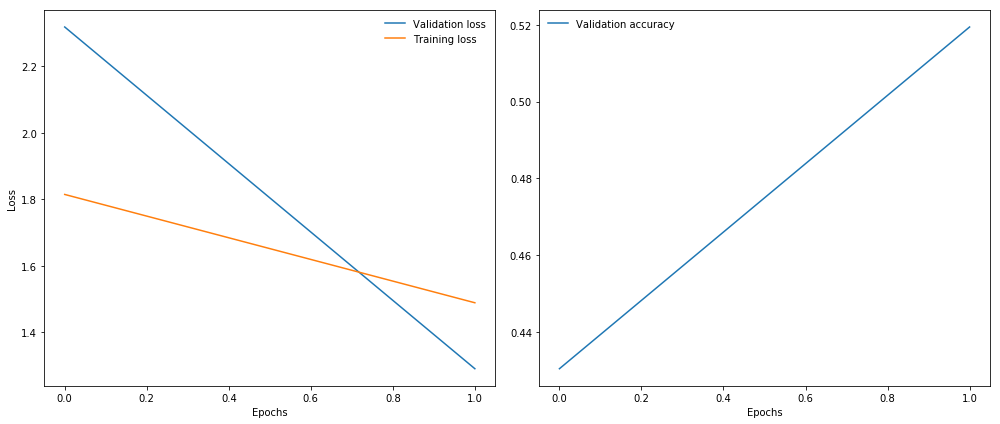

In [29]:

epochs = 2

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
lr= 1e-4
#optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=lr)
######### change the position of optim.step() in the train section
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, patience = 3, factor=0.1)

scheduler_scratch = optim.lr_scheduler.MultiStepLR(optimizer_scratch, [10, 18, 26, 32], 0.2)
stepsize = '10_18_26_32'

# create model name
save_path = './gdrive/My Drive/Colab Notebooks/Fer-dataset/'
modelname = '{}cnn-{}-lr{}-{}{}-epo{}.pt'.format(save_path, 'Adam', lr, 'Multi_', stepsize, epochs)


######################################################
############ start the training the model#############
######################################################

print(modelname)

#def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
model_scratch = train(epochs, dataloaders, model_scratch, 
                      optimizer_scratch, criterion_scratch, scheduler_scratch,
                      use_cuda, modelname)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(modelname))

### Test

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    print('test started at ', get_time())
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('test finished at ', get_time())
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:

# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)
